In [1]:
#импорт библиотек
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, UpSampling2D, AveragePooling2D, Conv2DTranspose, Input
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#загрузим датасет

batch_size = 64
image_size = 64

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/users/user/ai tests/archive/cats',
    label_mode= None,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    interpolation = 'area',
    seed=123
)

#препроцессинг
@tf.function
def process(x):
    #приводим значения пикселей к [0...1]
    return (x/256.0)

dataset = dataset.map(process)
dataset = dataset.shuffle(500).cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(50)

Found 15747 files belonging to 1 classes.


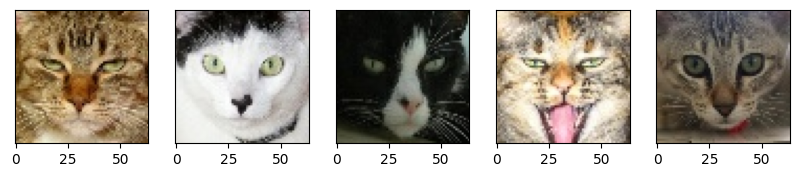

In [3]:
#посмотрим на картинки
def imshow(): 
    n = 5
    plt.figure(figsize=(10, 6))
    #берем один батч из датасета. проходимся по первым n
    for images in dataset.take(1):
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            
            plt.imshow(img, cmap='gist_gray')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [4]:



#код-сборщик нейросети

#количества фильтров на каждом из сверточных слоев
#с каждым слоем размер картинки уменьшается в 2 раза
widths = [32, 64, 96, 128]

#количество фильтров в латентном пространстве
latent_filters = 32

#размер латентного тензора по осям h и w
latent_size = 4

#количество res-net блоков на каждом уровне
num_blocks = 2


#реализуем res-net блок
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

#понижающий блок
def DownBlock(width, num_blocks):
    def apply(x):
        for _ in range(num_blocks):
            x = ResidualBlock(width)(x)
        x = AveragePooling2D(pool_size=2)(x)
        return x
    return apply

#повышающий блок
def UpBlock(width, num_blocks):
    def apply(x):
        x = UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(num_blocks):
            x = ResidualBlock(width)(x)
        return x
    return apply

def get_encoder(image_size, widths, latent_filters, num_blocks = 1):
    image = keras.Input(shape=(image_size, image_size, 3))
    x = image
    
    for width in widths:
        x = DownBlock(width, num_blocks)(x)
        
    x = Conv2D(latent_filters, kernel_size=1)(x)
    
    return keras.Model(image, x, name="encoder")

def get_decoder(latent_size, widths, latent_filters, num_blocks = 1):
    latent = keras.Input(shape=(latent_size, latent_size, latent_filters))
    
    x = latent
    
    for width in reversed(widths):
        x = UpBlock(width, num_blocks)(x)
        
    x = Conv2D(3, kernel_size=1, activation = 'sigmoid')(x)
    return keras.Model(latent, x, name="decoder")


In [6]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, latent_size, widths, block_depth):
        super().__init__()
        
        self.encoder = get_encoder(image_size, widths, latent_filters, num_blocks = num_blocks)
        self.decoder = get_decoder(latent_size, widths, latent_filters, num_blocks = num_blocks)
        
        self.lr = 1e-3
        self.enc_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        self.dec_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        
    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape_e,tf.GradientTape() as tape_d:
           
            latent = self.encoder(x, training=True)
            
            reconstructions = self.decoder(latent, training=True)

            reconstruction_loss = tf.reduce_mean((x - reconstructions) ** 2, axis = (1,2,3))
            total_loss = reconstruction_loss
            
        grads_e = tape_e.gradient(total_loss, self.encoder.trainable_variables)
        self.enc_optimizer.apply_gradients(zip(grads_e, self.encoder.trainable_variables))
        
        grads_d = tape_d.gradient(total_loss, self.decoder.trainable_variables)
        self.dec_optimizer.apply_gradients(zip(grads_d, self.decoder.trainable_variables))
        
        return total_loss
    


    def testing(self, n):
        for images in dataset.take(1):
            latent = self.encoder(images)
            recon = self.decoder(latent)
            for i in range(min(n, len(images))):
                ax = plt.subplot(3, n, i + 1)
                plt.imshow(images[i])
                plt.axis("off")


                ax = plt.subplot(3, n, i + 1 + n)
                plt.imshow(np.clip(recon[i].numpy(), 0, 1))
                plt.axis("off")

        plt.show()

model = DiffusionModel(image_size, latent_size, widths, num_blocks)

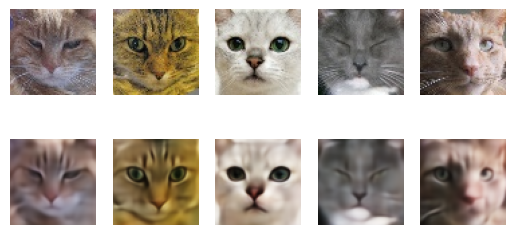

In [16]:
model.testing(5)

In [ ]:
#обучаем
epochs = 50
hist = np.array(np.empty([0]))
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        if tf.shape(x)[0] == batch_size: #проверяем целостность батча
            midloss += tf.reduce_mean(model.train_step(x), axis = 0)

        if(step == 10 ):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/10)))
           
            hist = np.append(hist, float(midloss/10))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            model.testing(5)

In [ ]:
model.encoder.save('encoder_3.h5')
model.decoder.save('decoder_3.h5')

In [9]:
model.encoder.load_weights('encoder_3.h5')
model.decoder.load_weights('decoder_3.h5')

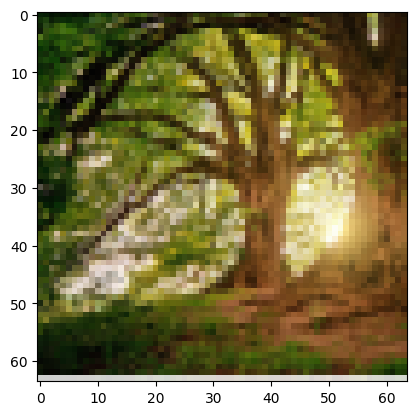

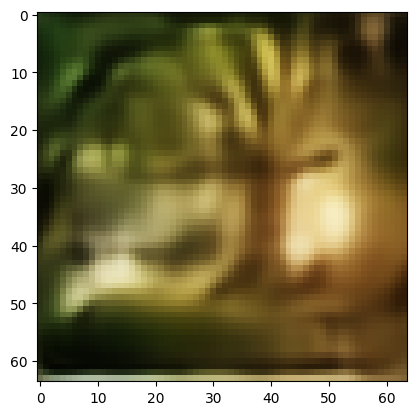

In [14]:
import cv2
img = cv2.imread("forest.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.cast(img, tf.float32)
img = tf.image.resize(img, (64,64), method = 'area')/256
plt.imshow(img)
plt.show()
img = tf.expand_dims(img, axis = 0)
latent = model.encoder(img)
result = model.decoder(latent)
img = tf.squeeze(result, axis =0)
plt.imshow(img)

In [17]:
model.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 3)   6           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   896         ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d_1[0][0]']         

 conv2d_16 (Conv2D)             (None, 8, 8, 128)    110720      ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_17 (Conv2D)             (None, 8, 8, 128)    147584      ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 8, 8, 128)    12416       ['average_pooling2d_2[0][0]']    
                                                                                                  
 add_6 (Add)                    (None, 8, 8, 128)    0           ['conv2d_17[0][0]',              
                                                                  'conv2d_15[0][0]']              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 8, 8, 128)   256         ['add_6[0][0]']                  
 rmalizati

In [18]:
print((64*64*3)/(4*4*32))

24.0
